In [1]:
using Markdown

# Monte Carlo (Concrete) Dropout: Bayesian Neural Network (BNN) for a regression task

From [https://github.com/aurelio-amerio/ConcreteDropout/blob/main/examples/Tensorflow/regression_MCDropout.ipynb](https://github.com/aurelio-amerio/ConcreteDropout/blob/main/examples/Tensorflow/regression_MCDropout.ipynb).
For more information on this BNN implementation, see https://arxiv.org/pdf/1703.04977.pdf

In [2]:
using Flux
using Flux.Optimise: update!
using Random
using StatsBase
using StatsPlots
using ConcreteDropoutLayer
using ConcreteDropoutLayer: Split

Random.seed!(MersenneTwister(1))

MersenneTwister(0xa7de458360d38f3af55a637edce179d2)

## Data

In [3]:
function gen_data(N; in=1, out=1)
    X = randn(Float32, Q, N)
    σ = 1
    w = 2
    b = 8
    Y = w * ones(out, in) * X .+ b + σ * randn(Float32, out, N)
    return X, Y
end

gen_data (generic function with 1 method)

## Neural network functions

In [4]:
function build_model_concrete_dropout(in, out)
    DL_model = Chain(
        Dense(in => 100, relu),
        Dense(100 => 100),
        ConcreteDropout(),
        relu,
        Dense(100 => 100),
        ConcreteDropout(),
        relu
    )

    est_mean = Chain(Dense(100 => out), ConcreteDropout(), relu)
    est_logvar = Chain(Dense(100 => out), ConcreteDropout(), relu)

    return Chain(DL_model, Split(est_mean, est_logvar)) |> f32
end

function build_model_dropout(in, out, p)
    DL_model = Chain(
        Dense(in => 100, relu),
        Dense(100 => 100),
        Dropout(p),
        relu,
        Dense(100 => 100),
        Dropout(p),
        relu
    )

    est_mean = Chain(Dense(100 => out), Dropout(p), relu)
    est_logvar = Chain(Dense(100 => out), Dropout(p), relu)

    return Chain(DL_model, Split(est_mean, est_logvar)) |> f32
end

build_model_dropout (generic function with 1 method)

## Loss functions

In [5]:
function heteroscedastic_loss(y_pred, y_true)
    D = size(y_pred, 1) ÷ 2
    μ = y_pred[1:D, :]
    log_var = y_pred[D+1:end, :]
    precision = exp.(-log_var)
    return sum(precision .* (y_true - μ) .^ 2 + log_var)
end

function full_loss(model, x, y; kwargs...)
    return heteroscedastic_loss(model(x), y) + add_CD_regularization(model[1]; kwargs...) + add_CD_regularization(model[2].paths[1]; kwargs...) + add_CD_regularization(model[2].paths[2]; kwargs...)
end

function simple_loss(model, x, y)
    return heteroscedastic_loss(model(x), y)
end

simple_loss (generic function with 1 method)

## Training functions

In [6]:
function train_step!(model, opt_state, xy, func_loss)
    # Calculate the gradient of the objective
    # with respect to the parameters within the model:
    loss, grads = Flux.withgradient(model) do m
        func_loss(m, xy...)
    end
    update!(opt_state, model, grads[1])
    return loss
end

"""
    train!(model, opt, data, func_loss, x_test, y_test, epochs)
Train the `model` and comute at each epoch the training and testing loss
"""
function train!(model, opt, data, func_loss, x_test, y_test, epochs)
    v_loss = Float32[]
    t_loss = Float32[]
    loss = rand(Float32) # just to define loss in outer loop scope # probably better ways to do that
    for epoch in 1:epochs
        for d in data
            loss = train_step!(model, opt, d, func_loss)
        end
        test_loss = heteroscedastic_loss(model(x_test), y_test)
        append!(v_loss, loss)
        append!(t_loss, test_loss)
        @info "Epoch $epoch train_loss = $(round(loss, digits = 4)) test_loss = $(round(test_loss, digits = 4))"
    end
    return v_loss, model, opt, t_loss
end

Main.var"##518".train!

# Data & Settings

In [7]:
Q = 1
D = 1
n_train = 1000
n_test = 1000

x_train, y_train = gen_data(n_train, in=Q, out=D)

x_test, y_test = gen_data(n_test, in=Q, out=D)

batch_size = 128
epochs = 100
data = Flux.DataLoader((x_train, y_train), batchsize=batch_size)

8-element DataLoader(::Tuple{Matrix{Float32}, Matrix{Float64}}, batchsize=128)
  with first element:
  (1×128 Matrix{Float32}, 1×128 Matrix{Float64},)

# Training

## Dropout Model

In [8]:
fix_dropout = 0.1
model_d = build_model_dropout(Q, D, fix_dropout)

Chain(
  Chain(
    Dense(1 => 100, relu),              # 200 parameters
    Dense(100 => 100),                  # 10_100 parameters
    Dropout(0.1),
    NNlib.relu,
    Dense(100 => 100),                  # 10_100 parameters
    Dropout(0.1),
    NNlib.relu,
  ),
  Split(
    Tuple(
      Chain(
        Dense(100 => 1),                # 101 parameters
        Dropout(0.1),
        NNlib.relu,
      ),
      Chain(
        Dense(100 => 1),                # 101 parameters
        Dropout(0.1),
        NNlib.relu,
      ),
    ),
  ),
)                   # Total: 10 arrays, 20_602 parameters, 81.539 KiB.

Initialise the optimiser for this model:

In [9]:
opt_state_d = Flux.setup(Adam(), model_d)
v_loss_d, model_out_d, opt_out_d, t_loss_d = train!(model_d, opt_state_d, data, simple_loss, x_test, y_test, epochs)

[ Info: Epoch 1 train_loss = 4928.0716 test_loss = 42064.9191
[ Info: Epoch 2 train_loss = 3323.4137 test_loss = 24775.6752
[ Info: Epoch 3 train_loss = 2015.4834 test_loss = 12677.6385
[ Info: Epoch 4 train_loss = 1928.3792 test_loss = 7564.604
[ Info: Epoch 5 train_loss = 1252.6181 test_loss = 6582.7492
[ Info: Epoch 6 train_loss = 1119.2636 test_loss = 6406.3642
[ Info: Epoch 7 train_loss = 1283.852 test_loss = 6100.9541
[ Info: Epoch 8 train_loss = 1080.3009 test_loss = 5730.1119
[ Info: Epoch 9 train_loss = 734.0531 test_loss = 5378.4608
[ Info: Epoch 10 train_loss = 723.3782 test_loss = 5072.1315
[ Info: Epoch 11 train_loss = 811.6239 test_loss = 4789.1269
[ Info: Epoch 12 train_loss = 596.7402 test_loss = 4501.4132
[ Info: Epoch 13 train_loss = 700.9662 test_loss = 4186.8965
[ Info: Epoch 14 train_loss = 696.2508 test_loss = 3847.7597
[ Info: Epoch 15 train_loss = 471.7808 test_loss = 3496.5949
[ Info: Epoch 16 train_loss = 394.1849 test_loss = 3111.3149
[ Info: Epoch 17 train_l

(Float32[4928.072, 3323.4138, 2015.4834, 1928.3793, 1252.618, 1119.2635, 1283.8519, 1080.3009, 734.0531, 723.3782  …  292.8923, 409.93234, 373.29517, 340.4589, 272.83926, 279.61685, 338.10355, 333.9525, 280.91696, 357.5548], Chain(Chain(Dense(1 => 100, relu), Dense(100 => 100), Dropout(0.1), relu, Dense(100 => 100), Dropout(0.1), relu), Split{Tuple{Chain{Tuple{Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, Dropout{Float64, Colon, TaskLocalRNG}, typeof(relu)}}, Chain{Tuple{Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, Dropout{Float64, Colon, TaskLocalRNG}, typeof(relu)}}}}((Chain(Dense(100 => 1), Dropout(0.1), relu), Chain(Dense(100 => 1), Dropout(0.1), relu)))), (layers = ((layers = ((weight = Leaf(Adam(0.001, (0.9, 0.999), 1.0e-8), (Float32[0.577728; -0.0713068; … ; 3.42359; -3.98309;;], Float32[31.5121; 171.951; … ; 354.144; 2624.81;;], (2.22967f-37, 0.448705))), bias = Leaf(Adam(0.001, (0.9, 0.999), 1.0e-8), (Float32[-1.23843, -2.26015, -0.17626, -0.895734, 

## Concrete Dropout Model

Compute the regularisation values

In [10]:
wr = get_weight_regularizer(n_train, l=1.0f-2, τ=1.0f0)
dr = get_dropout_regularizer(n_train, τ=1.0f0, cross_entropy_loss=false)

model = build_model_concrete_dropout(Q, D)
opt_state = Flux.setup(Adam(), model)
reg_loss(model, x, y) = full_loss(model, x, y; lw=wr, ld=dr)
v_loss, model_out, opt_out, t_loss = train!(model, opt_state, data, reg_loss, x_test, y_test, epochs)

[ Info: Epoch 1 train_loss = 6446.0959 test_loss = 58662.2008
[ Info: Epoch 2 train_loss = 5487.0425 test_loss = 48223.1309
[ Info: Epoch 3 train_loss = 3605.5548 test_loss = 27854.0226
[ Info: Epoch 4 train_loss = 1314.3724 test_loss = 8852.268
[ Info: Epoch 5 train_loss = 621.4794 test_loss = 4365.9777
[ Info: Epoch 6 train_loss = 1015.5954 test_loss = 4093.6648
[ Info: Epoch 7 train_loss = 1029.6658 test_loss = 4099.8226
[ Info: Epoch 8 train_loss = 466.1126 test_loss = 3935.2141
[ Info: Epoch 9 train_loss = 605.5356 test_loss = 3779.5602
[ Info: Epoch 10 train_loss = 645.4656 test_loss = 3638.6866
[ Info: Epoch 11 train_loss = 425.7896 test_loss = 3500.211
[ Info: Epoch 12 train_loss = 396.9243 test_loss = 3332.3597
[ Info: Epoch 13 train_loss = 648.5815 test_loss = 3172.2249
[ Info: Epoch 14 train_loss = 395.3741 test_loss = 3028.8853
[ Info: Epoch 15 train_loss = 416.8767 test_loss = 2885.0621
[ Info: Epoch 16 train_loss = 423.2138 test_loss = 2756.8704
[ Info: Epoch 17 train_los

(Float32[6446.0957, 5487.0425, 3605.555, 1314.3723, 621.47943, 1015.5954, 1029.6658, 466.11264, 605.5356, 645.46564  …  367.80893, 377.99216, 298.2239, 280.12592, 302.00815, 228.84969, 254.61754, 223.85211, 245.01727, 373.6146], Chain(Chain(Dense(1 => 100, relu), Dense(100 => 100), ConcreteDropout(0.0785), relu, Dense(100 => 100), ConcreteDropout(0.0744), relu), Split{Tuple{Chain{Tuple{Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, ConcreteDropout{Vector{Float32}, Colon, TaskLocalRNG}, typeof(relu)}}, Chain{Tuple{Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, ConcreteDropout{Vector{Float32}, Colon, TaskLocalRNG}, typeof(relu)}}}}((Chain(Dense(100 => 1), ConcreteDropout(0.0568), relu), Chain(Dense(100 => 1), ConcreteDropout(0.0767), relu)))), (layers = ((layers = ((weight = Leaf(Adam(0.001, (0.9, 0.999), 1.0e-8), (Float32[2.96642; 3.23642; … ; 6.35041; 0.923616;;], Float32[472.455; 1110.51; … ; 470.769; 304.133;;], (2.22967f-37, 0.448705))), bias = Leaf(Adam(0.00

# Result

## Training loss

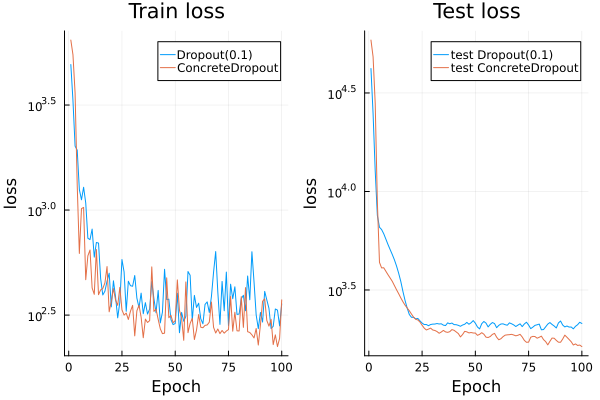

In [11]:
begin
    p_train = plot(v_loss_d, label="Dropout($fix_dropout)", title="Train loss")
    plot!(v_loss, label="ConcreteDropout")
    xlabel!("Epoch")
    ylabel!("loss", yscale = :log10)
    p_test = plot(t_loss_d, label="test Dropout($fix_dropout)", title="Test loss")
    plot!(t_loss, label="test ConcreteDropout")
    xlabel!("Epoch")
    ylabel!("loss", yscale = :log10)
    plot(p_train, p_test)
end

## Monte Carlo predictions

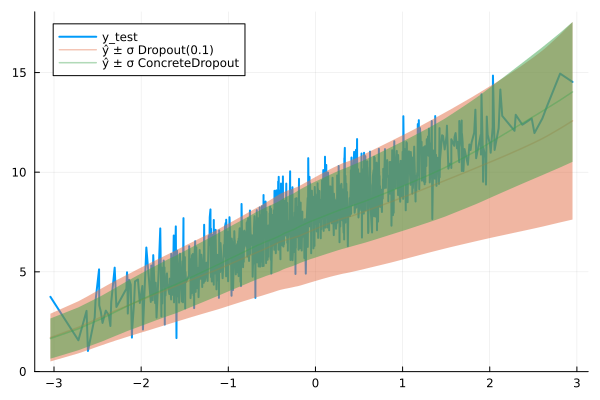

In [12]:
#! only work with D = out = 1 as it is coded now
"""
MC_predict(model, X::AbstractArray{T}; n_samples=1000, kwargs...)
For each X it returns `n_samples` monte carlo simulations where the randomness comes from the (Concrete)Dropout layers.
"""
function MC_predict(model, X::AbstractArray; n_samples=1000, heteroscedastic=true, kwargs...)
    dim_out = Flux.outputsize(model, size(X))[1]
    D = heteroscedastic ? dim_out ÷ 2 : dim_out
    dim_N = ndims(X)
    mean_arr = zeros(D, size(X, dim_N))
    std_dev_arr = zeros(D, size(X, dim_N))

    for (i, x) in enumerate(eachslice(X, dims=dim_N))
        X_in = cat(fill(x, n_samples)..., dims=dim_N)

        predictions = model(X_in)
        θs_MC = predictions[1:D, :]
        logvars = predictions[D+1:end, :]

        θ_hat = mean(θs_MC, dims=2) # predictive_mean

        θ2_hat = mean(θs_MC .^ 2, dims=2)
        var_mean = mean(exp.(logvars), dims=2) # aleatoric_uncertainty
        total_var = θ2_hat - θ_hat .^ 2 + var_mean
        std_dev = sqrt.(total_var)

        mean_arr[:, i] .= θ_hat
        std_dev_arr[:, i] .= std_dev
    end
    return mean_arr, std_dev_arr
end

y_pred, y_std = MC_predict(model_out, x_test)
y_pred_d, y_std_d = MC_predict(model_out_d, x_test)

begin
    argsort = sortperm(x_test, dims=2)
    x_sorted = x_test[argsort]'
    y_true_sorted = y_test[argsort]'

    plot(x_sorted, y_true_sorted, label="y_test", lw = 2)
    plot!(x_sorted, y_pred_d[argsort]', ribbon=y_std_d[argsort]', label="ŷ ± σ Dropout(0.1)", alpha=0.4, lw = 1.5)
    plot!(x_sorted, y_pred[argsort]', ribbon=y_std[argsort]', label="ŷ ± σ ConcreteDropout", alpha=0.4, lw = 1.5)
end

Print all learned Dropout rates.

In [13]:
for layer in [model_out[1]...; model_out[2][1]...; model_out[2][2]...]
    if layer isa ConcreteDropout
        println(layer)
    end
end

ConcreteDropout(0.0785)
ConcreteDropout(0.0744)
ConcreteDropout(0.0568)
ConcreteDropout(0.0767)


---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*